<a href="https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GREMLIN_simple

This is a bare minimum version of GREMLIN (no sequence weighting, gap removal, etc), intended for educational/demo purposes.  For the full version see [GREMLIN_TF_v2.1](https://colab.research.google.com/github/sokrypton/GREMLIN_CPP/blob/master/GREMLIN_TF.ipynb) 

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# <so@g.harvard.edu> and <pkk382@g.harvard.edu> wrote this code.
# As long as you retain this notice, you can do whatever you want
# with this stuff. If we meet someday, and you think this stuff
# is worth it, you can buy us a beer in return.
# --Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

## Load some libraries

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt

## Convert FASTA to MSA np.array()

In [0]:
def parse_fasta(filename):
  '''function to parse fasta file'''
  header = []
  sequence = []
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if line[0] == ">":
      header.append(line[1:])
      sequence.append([])
    else:
      sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]
  return np.array(header), np.array(sequence)
  
def mk_msa(seqs):
  '''one hot encode msa'''
  
  ################
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {}
  for a,n in zip(alphabet,range(states)):
    a2n[a] = n

  def aa2num(aa):
    '''convert aa into num'''
    if aa in a2n: return a2n[aa]
    else: return a2n['-']
  ################
  
  msa = []
  for seq in seqs:
    msa.append([aa2num(aa) for aa in seq])
  msa_ori = np.array(msa)
  return msa_ori, tf.keras.utils.to_categorical(msa_ori,states)

## load example

In [0]:
!wget -q -nc https://gremlin2.bakerlab.org/db/PDB_EXP/fasta/4FAZA.fas

In [5]:
names,seqs = parse_fasta("4FAZA.fas")
msa_ori, msa = mk_msa(seqs)

print(msa_ori.shape)
print(msa.shape)

(817, 62)
(817, 62, 21)


## GREMLIN
GREMLIN is technically an "autoencoder" with a single dense (or fully-connected) layer between the input and output, with no hidden variables. GREMLIN tries to minimize the difference between the input and output.  The "latent" variables are the (w)eights/(b)ias of the dense layer.

* loss = categorical_crossentropy(msa,  softmax(dot(msa, w) + b))
 - the math is identical to computing the "pseudolikelihood" as in GREMLIN()
 
* msa
 - msa.shape = (batch, L x 21)
 - 21 =  (20 amino acids + 1 gap) categories
* w = weight
 - w.shape = (L x 21, L x 21)
 -  aka two-body term of the MRF (aka co-evolution)
 -  note: the w matrix is symmetrized and the diagional is set to zero
* b = bias 
 - b.shape = (L x 21)
 - aka one-body-term of the MRF (aka conservation)

In [0]:
def GREMLIN_simple(msa, opt_iter=100):
  
  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence
  states = msa.shape[2] # number of states (or categories)

  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # setting up weights
  b = tf.get_variable("b", [ncol,states])
  w = tf.get_variable("w", [ncol,states,ncol,states], 
                      initializer=tf.initializers.zeros)

  # symmetrize w
  w = w * np.reshape(1-np.eye(ncol),(ncol,1,ncol,1))
  w = w + tf.transpose(w,[2,3,0,1])
  
  # input
  MSA = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa")

  # dense layer + softmax activation
  MSA_pred = tf.nn.softmax(tf.tensordot(MSA,w,2)+b,-1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(MSA,MSA_pred))

  # add L2 regularization
  reg_b = 0.01 * tf.reduce_sum(tf.square(b))
  reg_w = 0.01 * tf.reduce_sum(tf.square(w)) * 0.5 * (ncol-1) * (states-1)
  loss = loss + reg_b + reg_w

  # setup optimizer
  learning_rate = 0.1 * np.log(nrow)/ncol
  opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)

  # optimize!
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # initialize bias
    pc = 0.01 * np.log(nrow)
    b_ini = np.log(np.sum(msa,0) + pc)
    b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
    sess.run(b.assign(b_ini))
    
    print("starting",sess.run(loss,{MSA:msa}))

    for i in range(opt_iter):
      sess.run(opt,{MSA:msa})
      if (i+1) % 10 == 0:
        print((i+1),sess.run(loss,{MSA:msa}))

      # save the weights (aka V and W parameters of the MRF)
      V = sess.run(b)
      W = sess.run(w)
  return(V,W) 

In [7]:
V,W = GREMLIN_simple(msa)

starting 80407.195
10 42247.95
20 38261.23
30 36949.69
40 36504.938
50 36318.098
60 36232.797
70 36190.547
80 36166.117
90 36149.684
100 36137.15


## get contacts

In [0]:
def get_mtx(W):
  # l2norm of 20x20 matrices (note: we ignore gaps)
  raw = np.sqrt(np.sum(np.square(W[:,:-1,:,:-1]),(1,3)))

  # apc (average product correction)
  ap = np.sum(raw,0,keepdims=True)*np.sum(raw,1,keepdims=True)/np.sum(raw)
  apc = raw - ap
  np.fill_diagonal(apc,0)
  
  return(raw,apc)

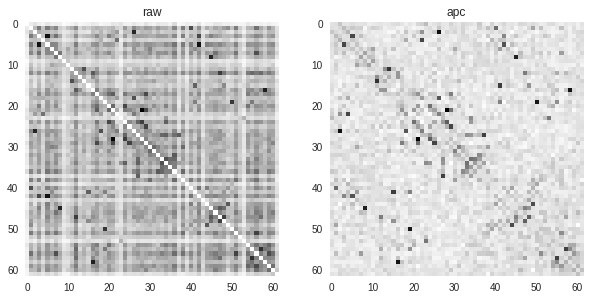

In [9]:
raw, apc = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw)
plt.grid(False)
plt.title("raw")
plt.subplot(1,2,2)
plt.imshow(apc)
plt.grid(False)
plt.title("apc")
plt.show()

## EXTRA!
Now lets try expand GREMLIN a bit, by adding sequence weights and ability to do stocastic gradient decent


In [0]:
from scipy.spatial.distance import pdist,squareform
def get_eff(msa,eff_cutoff=0.8):
  '''compute effective weight for each sequence'''
  
  # pairwise identity
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))

  # weight for each sequence
  msa_w = np.zeros_like(msa_sm)
  msa_w[np.where(msa_sm >= eff_cutoff)] = 1
  msa_w = 1/np.sum(msa_w,-1)
  
  return msa_w

In [0]:
# compute weight for each sequence in the MSA
msa_weights = get_eff(msa_ori)

In [0]:
def GREMLIN_simple_v2(msa, msa_weights=None, opt_iter=100, opt_rate=0.1, batch_size=None):

  # collecting some information about input msa
  nrow = msa.shape[0] # number of sequences
  ncol = msa.shape[1] # length of sequence
  states = msa.shape[2] # number of states (or categories)
  
  if msa_weights is None:
    msa_weights = np.ones(nrow)
  
  neff = np.sum(msa_weights) # number of "effective" sequences

  # kill any existing tensorflow graph
  tf.reset_default_graph()

  # setting up weights
  b = tf.get_variable("b", [ncol,states])
  w = tf.get_variable("w", [ncol,states,ncol,states],
                      initializer=tf.initializers.zeros)

  # symmetrize w
  w = w * np.reshape(1-np.eye(ncol),(ncol,1,ncol,1))
  w = w + tf.transpose(w,[2,3,0,1])
  
  # input
  MSA = tf.placeholder(tf.float32,shape=(None,ncol,states),name="msa")
  MSA_weights = tf.placeholder(tf.float32,shape=(None,),name="msa_weights")

  # dense layer + softmax activation
  MSA_pred = tf.nn.softmax(tf.tensordot(MSA,w,2)+b,-1)

  # loss = categorical crossentropy (aka pseudo-likelihood)
  loss = tf.reduce_sum(tf.keras.losses.categorical_crossentropy(MSA,MSA_pred),-1)
  loss = tf.reduce_sum(loss * MSA_weights) / tf.reduce_sum(MSA_weights)

  # add L2 regularization
  reg_b = 0.01 * tf.reduce_sum(tf.square(b))
  reg_w = 0.01 * tf.reduce_sum(tf.square(w)) * 0.5 * (ncol-1) * (states-1)
  loss = loss + (reg_b + reg_w)/neff

  # setup optimizer
  learning_rate = opt_rate * np.log(nrow)/ncol
  opt = tf.train.AdamOptimizer(learning_rate).minimize(loss)
  
  # generate input/feed
  def feed(feed_all=False):
    if batch_size is None or feed_all:
      return {MSA:msa, MSA_weights:msa_weights}
    else:
      idx = np.random.randint(0,nrow,size=batch_size)
      return {MSA:msa[idx], MSA_weights:msa_weights[idx]}
  
  # optimize
  with tf.Session() as sess:
    
    # initialize
    sess.run(tf.global_variables_initializer())
    
    # initialize bias
    pc = 0.01 * np.log(neff)
    b_ini = np.log(np.sum(msa.T * msa_weights,-1).T + pc)
    b_ini = b_ini - np.mean(b_ini,-1,keepdims=True)
    sess.run(b.assign(b_ini))
    
    # compute loss across all data
    get_loss = lambda: round(sess.run(loss,feed(feed_all=True)) * neff,2)
    print("starting", get_loss())

    # iterate!
    for i in range(opt_iter):
      sess.run(opt,feed())
      if (i+1) % int(opt_iter/10) == 0:
        print("iter",(i+1),get_loss())
 
    # save the weights (aka V and W parameters of the MRF)
    V = sess.run(b)
    W = sess.run(w)
      
  # return the learned weights!
  return V, W

In [13]:
%%time
V,W = GREMLIN_simple_v2(msa, msa_weights, opt_iter=100, batch_size=10)

starting 51135.13
iter 10 57286.79
iter 20 55181.01
iter 30 49599.23
iter 40 45240.79
iter 50 42424.07
iter 60 41133.15
iter 70 40757.51
iter 80 40471.31
iter 90 40692.86
iter 100 40493.17
CPU times: user 1.33 s, sys: 157 ms, total: 1.49 s
Wall time: 1.26 s


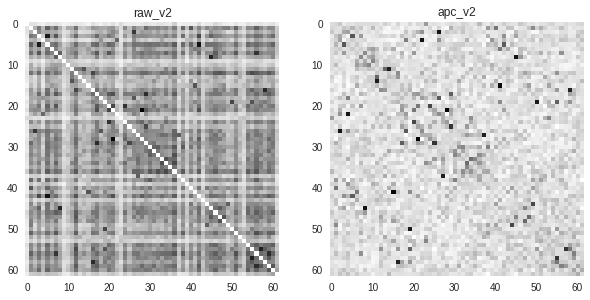

In [14]:
raw_v2, apc_v2 = get_mtx(W)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(raw_v2)
plt.grid(False)
plt.title("raw_v2")
plt.subplot(1,2,2)
plt.imshow(apc_v2)
plt.grid(False)
plt.title("apc_v2")
plt.show()